# Machine Learning

## Imports

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, PassiveAggressiveRegressor, RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn import tree

from joblib import dump

import math

## Découpage du dataset

In [77]:
df = pd.read_csv('../csv/donnees_clean.csv')

In [78]:
X = df.drop('charges', axis=1)
y = df['charges']

In [79]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,Oui,southwest,16884.92
1,18,male,33.8,1,Non,southeast,1725.55
2,28,male,33.0,3,Non,southeast,4449.46
3,33,male,22.7,0,Non,northwest,21984.47
4,32,male,28.9,0,Non,northwest,3866.86
...,...,...,...,...,...,...,...
1332,50,male,31.0,3,Non,northwest,10600.55
1333,18,female,31.9,0,Non,northeast,2205.98
1334,18,female,36.9,0,Non,southeast,1629.83
1335,21,female,25.8,0,Non,southwest,2007.94


## Nettoyage des données

In [80]:
def bmi(bmi):
    if bmi < 18.5:
        return "maigreur"
    elif bmi < 25:
        return "normal"
    elif bmi < 30:
        return "surpoids"
    elif bmi < 35:
        return "obesite_moderee"
    elif bmi < 40:
        return "obesite_severe"
    else:
        return "obesite_morbide"

In [81]:
# for i in df.index:
#     if df['smoker'][i] == 'Non':
#         df['bmi'][i] = df['bmi'][i] / 0.293656

In [82]:
X['bmi'] = X['bmi'].apply(lambda x : bmi(x))
del X['region']

X

,age,sex,bmi,children,smoker
0,19,female,surpoids,0,Oui
1,18,male,obesite_moderee,1,Non
2,28,male,obesite_moderee,3,Non
3,33,male,normal,0,Non
4,32,male,surpoids,0,Non
...,...,...,...,...,...
1332,50,male,obesite_moderee,3,Non
1333,18,female,obesite_moderee,0,Non
1334,18,female,obesite_severe,0,Non
1335,21,female,surpoids,0,Non


## Train_set & Test_set

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.95, random_state=42)
X_train.head()

,age,sex,bmi,children,smoker
1302,43,male,surpoids,0,Oui
296,19,male,surpoids,0,Oui
573,62,female,obesite_severe,1,Non
1132,52,female,maigreur,0,Non
471,18,female,obesite_moderee,0,Non


## Dummy Modèle

In [84]:
dummy = DummyRegressor()

In [85]:
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.004178723670794193

## Création des Modèles

In [86]:
cat_var = ['smoker', 'sex', 'bmi']
num_var = ['age', 'children']

cat_transformer = OneHotEncoder(drop='if_binary')
num_transformer = RobustScaler()

encoder = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var),
        ('num', num_transformer, num_var)
    ], 
    remainder='passthrough'
)

In [87]:
encoder.fit_transform(X).shape

(1337, 10)

### Résultats avec hyperparamètres sélectionnés

In [88]:
model = DecisionTreeRegressor()

pipe = Pipeline([
    ('enc', encoder),
    ('model', model)
])
    
string = str(model)

param_grid = {
    'model__criterion': ["squared_error", "friedman_mse", "absolute_error", \
            "poisson"],
    'model__splitter': ["best", "random"],
    'model__max_depth': np.arange(1, 50, 1),
    'model__min_samples_split': np.arange(1, 50, 1),
    'model__min_samples_leaf': np.arange(1, 50, 1),
    'model__min_impurity_decrease': np.arange(0.1, 10, 0.1),
}

grid = RandomizedSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)

score = grid.best_score_
score = round(score,4)

params = grid.best_params_

# score_rmse = math.sqrt(mean_squared_error(y_test, prediction))

print(f"###### Modèle : {model}, Meilleur score : {round(score *100, 2)}%, Meilleurs paramètres : {params}")

###### Modèle : DecisionTreeRegressor(), Meilleur score : 82.93%, Meilleurs paramètres : {'model__splitter': 'best', 'model__min_samples_split': 12, 'model__min_samples_leaf': 32, 'model__min_impurity_decrease': 0.7000000000000001, 'model__max_depth': 6, 'model__criterion': 'poisson'}


Modèle : DecisionTreeRegressor(), Meilleur score : 67.94%, Meilleurs paramètres : {'model__splitter': 'best', 'model__min_weight_fraction_leaf': 0.14, 'model__min_samples_split': 25, 'model__min_samples_leaf': 4, 'model__min_impurity_decrease': 5.7, 'model__max_depth': 17, 'model__criterion': 'squared_error'}


Modèle : DecisionTreeRegressor(), Meilleur score : 77.85%, Meilleurs paramètres : {'model__splitter': 'best', 'model__min_weight_fraction_leaf': 0.04, 'model__min_samples_split': 41, 'model__min_samples_leaf': 14, 'model__min_impurity_decrease': 5.6, 'model__max_depth': 7, 'model__criterion': 'poisson'}


Modèle : DecisionTreeRegressor(), Meilleur score : 80.77%, Meilleurs paramètres : {'model__splitter': 'random', 'model__min_weight_fraction_leaf': 0.02, 'model__min_samples_split': 21, 'model__min_samples_leaf': 35, 'model__min_impurity_decrease': 1.1, 'model__max_depth': 42, 'model__criterion': 'absolute_error'}


Modèle : DecisionTreeRegressor(), Meilleur score : 82.89%, Meilleurs paramètres : {'model__splitter': 'best', 'model__min_weight_fraction_leaf': 0.03, 'model__min_samples_split': 28, 'model__min_samples_leaf': 20, 'model__min_impurity_decrease': 4.0, 'model__max_depth': 14, 'model__criterion': 'poisson'}

Modèle : DecisionTreeRegressor(), Meilleur score : 83.05%, Meilleurs paramètres : {'model__splitter': 'best', 'model__min_weight_fraction_leaf': 0.01, 'model__min_samples_split': 41, 'model__min_samples_leaf': 20, 'model__min_impurity_decrease': 4.1, 'model__max_depth': 23, 'model__criterion': 'absolute_error'}

In [89]:
# model = DecisionTreeRegressor()

# pipe = Pipeline([
#     ('enc', encoder),
#     ('model', model)
# ])
    
# string = str(model)

# param_grid = {
#     'model__min_samples_split': np.arange(30, 40, 1),
#     'model__max_depth': np.arange(10, 15, 1),
#     'model__min_samples_leaf': np.arange(5, 10, 1),
#     'model__min_impurity_decrease': np.arange(0, 8, 0.5),
# }

# grid = GridSearchCV(pipe, param_grid, verbose=3, cv=5)

# grid.fit(X_train, y_train)

# score = grid.best_score_
# score = round(score,4)

# params = grid.best_params_

# # score_rmse = math.sqrt(mean_squared_error(y_test, prediction))

# print(f"###### Modèle : {model}, Meilleur score : {round(score *100, 2)}%, Meilleurs paramètres : {params}")

Pour chaque hyper-paramètre du décision Tree, indiquez si en l’augmentant ou le baissant on joue: sur le biais, la variance et/ou le temps de calcul :

    - Max_depth correspond à la profondeur de notre arbre. Plus il est élevé => le biais réduit, la variance augmente, les calculs augmentent.

    - min_samples_split est le nombre minimum d'échantillons requis pour diviser un nœud interne. Plus il est élevé => le biais augmente, la variance réduit, les calculs augmentent.

    - min_samples_leaf est le nombre minimum d'échantillons requis pour être à un nœud feuille. Plus il est élevé => le biais augmente, la variance réduit, les calculs augmentent.

    - min_impurity_decrease représente la pureté d'une feuille. Plus il est élevé => le biais augmente, la variance réduit, les calculs augmentent.

Pour la régression, faut-il standardiser y ?

    - Standardiser y pour la régression ne changera rien, cela deviendra utile pour la classification afin d'éviter les minimums locaux lors de la descente de gradients.

Qu’est ce qu’une Shap-Value ?

    - La shap-value va permettre d'expliquer notre modèle. Ainsi en calculant l'importance de chacunes de nos variables dans notre modèle, on va pouvoir déterminer la shap-value de chacune de celles-ci. Nous pourrons donc pouvoir expliquer à n'importe qui comment nos prédictions sont contruites.

Qu’est ce que le bagging? le boosting? et les modèles correspondant? Qu’est ce que le voting? le stacking?

    - Il s'agit "d'Ensemble Learning", ils permettent d'entraîner plusieurs modèles forts afin de considérer l'ensemble de leurs prédictions. Il s'agit là de la loi des grands nombres (plusieurs avis valent mieux qu'un). Voyons différents types d'ensemble learning :
        - Le bagging : Il créé plusieurs copies d'un meme modèle et l'entraîne sur une partie aléatoire du dataset => RandomForest. Modèles entrainés en parallèles (tous les modèles se trouvent en overfitting). Cela va permettre de réduire la variance.
        - Le boosting : Entraîne des modèles faibles qui chacun pour objectif de corriger les erreurs du modèle précédent => AdaBoost, GradientBoosting. Modèles entrainés en séries (tous les modèles se trouvent en underfitting). Cela va permettre de réduire le biais.
        - Le stacking : Va permettre d'entrainer un nouveau modèle au dessus de notre foule de modèle déjà entrainé. Grâce aux prédictions de tous nos modèles, le modèle choisi va apprendre à prédire le résultat final par lui-même.
        - Le voting : Ce modèle va prendre en compte les décisions de tous les modèles qui lui sont attribués pour prendre sa décision en fonction de la majorité des "votes".




In [90]:
model = DecisionTreeRegressor(splitter='best', criterion="squared_error", max_depth=13, min_samples_split=35, min_impurity_decrease=0, min_samples_leaf=5)

pipe = Pipeline([
    ('enc', encoder),
    ('model', model),
])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
score_r2 = r2_score(y_test, prediction)
score_mse = mean_squared_error(y_test, prediction)
score_mae = mean_absolute_error(y_test, prediction)

print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(score_r2 *100, 2)}%, MSE score : {round(score_mse,2)}, MSE score : {round(score_mae,2)}")

Nom du modèle : Pipeline, R2 score : 90.61%, MSE score : 19465783.74, MSE score : 2598.79


In [96]:
model

Pipeline(steps=[('enc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['smoker', 'sex', 'bmi']),
                                                 ('num', RobustScaler(),
                                                  ['age', 'children'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=13, min_impurity_decrease=0,
                                       min_samples_leaf=5,
                                       min_samples_split=35))])

In [94]:
model.get_params()

{'memory': None,
 'steps': [('enc', ColumnTransformer(remainder='passthrough',
                     transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                    ['smoker', 'sex', 'bmi']),
                                   ('num', RobustScaler(), ['age', 'children'])])),
  ('model',
   DecisionTreeRegressor(max_depth=13, min_impurity_decrease=0, min_samples_leaf=5,
                         min_samples_split=35))],
 'verbose': False,
 'enc': ColumnTransformer(remainder='passthrough',
                   transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                  ['smoker', 'sex', 'bmi']),
                                 ('num', RobustScaler(), ['age', 'children'])]),
 'model': DecisionTreeRegressor(max_depth=13, min_impurity_decrease=0, min_samples_leaf=5,
                       min_samples_split=35),
 'enc__n_jobs': None,
 'enc__remainder': 'passthrough',
 'enc__sparse_threshold': 0.3,
 'enc__transformer_weights': None,
 'enc__

In [97]:
model.best_estimator_.named_steps['model']

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

[Text(0.6821120689655172, 0.9545454545454546, 'x[0] <= 0.5\nsquared_error = 146551117.865\nsamples = 1337\nvalue = 13279.122'),
 Text(0.430316091954023, 0.8636363636363636, 'x[8] <= 0.14\nsquared_error = 35881947.08\nsamples = 1063\nvalue = 8440.66'),
 Text(0.25, 0.7727272727272727, 'x[9] <= -0.25\nsquared_error = 22158635.105\nsamples = 595\nvalue = 5405.168'),
 Text(0.14367816091954022, 0.6818181818181818, 'x[8] <= -0.26\nsquared_error = 16984715.424\nsamples = 252\nvalue = 3859.616'),
 Text(0.10344827586206896, 0.5909090909090909, 'x[8] <= -0.66\nsquared_error = 15464536.125\nsamples = 206\nvalue = 3277.46'),
 Text(0.05747126436781609, 0.5, 'x[4] <= 0.5\nsquared_error = 11625538.721\nsamples = 120\nvalue = 2593.582'),
 Text(0.034482758620689655, 0.4090909090909091, 'x[6] <= 0.5\nsquared_error = 3643206.511\nsamples = 84\nvalue = 2162.0'),
 Text(0.022988505747126436, 0.3181818181818182, 'x[1] <= 0.5\nsquared_error = 617876.75\nsamples = 62\nvalue = 1898.909'),
 Text(0.011494252873563

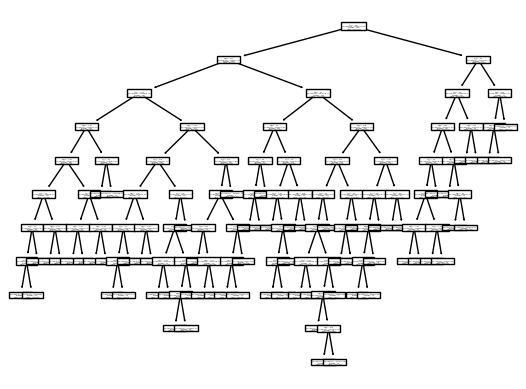

In [ ]:
clf = tree.DecisionTreeRegressor(splitter='best', criterion="squared_error", max_depth=13, min_samples_split=35, min_impurity_decrease=0, min_samples_leaf=5)
clf = clf.fit(encoder.transform(X), y)

tree.plot_tree(clf)

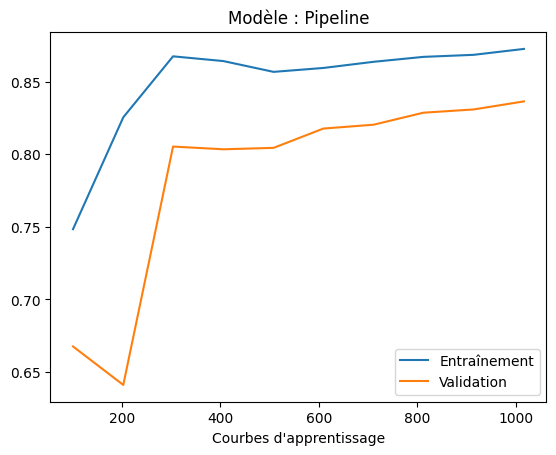

In [ ]:
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=5)


plt.plot(N, train_score.mean(axis=1), label='Entraînement')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.title(f"Modèle : {model.__class__.__name__}")
plt.xlabel('Courbes d\'apprentissage')
plt.legend()
plt.show()

## Sélection et enregistrement du Modèle

In [ ]:
prediction = model.predict(X_test)

prediction = model.predict(X_test)
score_r2 = math.sqrt(r2_score(y_test, prediction))
score_mse = math.sqrt(mean_squared_error(y_test, prediction))
score_mae = math.sqrt(mean_absolute_error(y_test, prediction))
    
print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(score_r2 *100, 2)}%, MSE score : {round(score_mse,2)}, MSE score : {round(score_mae,2)}")

Nom du modèle : Pipeline, R2 score : 95.19%, MSE score : 4412.0, MSE score : 50.98
